In this notebook, I show how to fine-tune a NLLB-200 machine translation model for a new language.

The new language will be Mansi, and I will use a Tyvan-Russian parallel corpus as the training data.

I am running this notebook on Google Colab with a T4 GPU that has 15Gb of memory. If you run it elsewhere, you may want to adjust the batch size, so that there are no OOM errors, but the GPU is well utilized.

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

# Init

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install sentencepiece transformers datasets sacremoses sacrebleu matplotlib protobuf tensorboard -q

In [3]:
import random
import re
from datetime import datetime
import pandas as pd
import numpy as np

import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer

from tqdm.auto import tqdm, trange
import gc
import torch
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, NllbTokenizer, set_seed
from transformers.models.nllb.tokenization_nllb import FAIRSEQ_LANGUAGE_CODES
import sacrebleu

from collections import Counter
import sentencepiece as spm
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
import json
import os
import shutil

from torch.utils.tensorboard import SummaryWriter

set_seed(42)
def set_seeed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True  # Детерминированность для операций с CUDA
        torch.backends.cudnn.benchmark = False     # Отключение автоматической оптимизации для ускорения
set_seeed(42)

import transformers
transformers.__version__

'4.44.2'

# Preprocessing the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [5]:
def process_and_save_splits(data_path: str):
    """
    Process the input CSV file by renaming columns, splitting into train, val, test, 
    and saving each split with a custom file naming pattern.
    
    Args:
        data_path (str): Path to the input CSV file.
    
    Returns:
        tuple: Tuple containing train, val, and test DataFrames.
    """
    # Чтение файла
    df = pd.read_csv(data_path)
    print(f"data.shape unprocessed: {df.shape}")
    print(f"df.columns unprocessed: {df.columns}")

    # Переименование колонок
    df = df.rename(columns={
        'Unnamed: 0': 'row_id',
        'target': 'mansi',
        'source': 'ru'
    })

    df['ind'] = df.index

    # Сплит данных
    np.random.seed(42)
    df['split'] = np.random.choice(['train', 'val', 'test'], size=len(df), p=[0.9, 0.05, 0.05])

    print(f"data.shape processed: {df.shape}")
    print(f"df.columns processed: {df.columns}")
    print(f"{df['split'].value_counts()}")

    # Разделение на три датафрейма
    df_train = df[df.split == 'train'].copy()
    df_val = df[df.split == 'val'].copy()
    df_test = df[df.split == 'test'].copy()

    # Генерация имен файлов
    train_file = data_path.replace(".csv", "_train_09.csv")
    val_file = data_path.replace(".csv", "_val_005.csv")
    test_file = data_path.replace(".csv", "_test_005.csv")

    # Сохранение файлов
    df_train.to_csv(train_file, index=False)
    df_val.to_csv(val_file, index=False)
    df_test.to_csv(test_file, index=False)

    return df_train, df_val, df_test

In [6]:
data_path = 'cleared_v1.1.csv'
df_train_mansi_v1, df_val_mansi_v1, df_test_mansi_v1 = process_and_save_splits(data_path)

df_train_mansi_v2, df_val_mansi_v2, df_test_mansi_v2 = process_and_save_splits('cleared_v2.csv')

data.shape unprocessed: (80879, 2)
df.columns unprocessed: Index(['target', 'source'], dtype='object')
data.shape processed: (80879, 4)
df.columns processed: Index(['mansi', 'ru', 'ind', 'split'], dtype='object')
split
train    72943
val       4025
test      3911
Name: count, dtype: int64
data.shape unprocessed: (79933, 2)
df.columns unprocessed: Index(['target', 'source'], dtype='object')
data.shape processed: (79933, 4)
df.columns processed: Index(['mansi', 'ru', 'ind', 'split'], dtype='object')
split
train    72086
val       3973
test      3874
Name: count, dtype: int64


In [129]:
df_train_mansi_v1 = pd.read_csv("cleared_v1.1_train_09.csv")
df_test_mansi_v1 = pd.read_csv("cleared_v1.1_test_005.csv")
df_val_mansi_v1 = pd.read_csv("cleared_v1.1_val_005.csv")

In [5]:
df_train_mansi_v2 = pd.read_csv("cleared_v2_train_09.csv")
df_test_mansi_v2 = pd.read_csv("cleared_v2_test_005.csv")
df_val_mansi_v2 = pd.read_csv("cleared_v2_val_005.csv")

df_test_val_v2 = pd.concat([df_test_mansi_v2, df_val_mansi_v2])
print(df_test_val_v2.shape)
df_test_val_v2.head(2)

In [16]:
df_train_mansi_v3_1 = pd.read_csv("cleared_v3.1/small_macrons_changed/cleared_v3_train_09.csv")
df_test_mansi_v3_1 = pd.read_csv("cleared_v3.1/small_macrons_changed/cleared_v3_test_005.csv")
df_val_mansi_v3_1 = pd.read_csv("cleared_v3.1/small_macrons_changed/cleared_v3_val_005.csv")

df_train_mansi_v3_1 = df_train_mansi_v3_1.rename(columns={"rus": "ru"})
df_test_mansi_v3_1 = df_test_mansi_v3_1.rename(columns={"rus": "ru"})
df_val_mansi_v3_1 = df_val_mansi_v3_1.rename(columns={"rus": "ru"})

df_test_val_v3_1 = pd.concat([df_test_mansi_v3_1, df_val_mansi_v3_1])
print(df_test_mansi_v3_1.shape)
print(df_test_val_v3_1.shape)
df_val_mansi_v3_1.head(2)

(3874, 3)
(7847, 3)


,mansi,ru,split
0,"Ущта махум щагтмыт: ""Ань тай тах ущта олэв!""","Жители селения обрадовались: ""Наконец-то будем...",val
1,Ты пилысьмаӈ ма̄.,Это опасное место.,val


# Тесты токенайзера

In [ ]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

In [ ]:
smpl = df_train_mansi.sample(10000, random_state=1)

smpl['rus_toks'] = smpl["ru"].apply(tokenizer.tokenize)
smpl['mansi_toks'] = smpl["mansi"].apply(tokenizer.tokenize)

smpl['rus_words'] = smpl["ru"].apply(word_tokenize)
smpl['mansi_words'] = smpl["mansi"].apply(word_tokenize)

In [ ]:
smpl.sample(5)[['mansi', 'mansi_words', 'mansi_toks', 'ru', 'rus_words', 'rus_toks']]

In [ ]:
stats = smpl[['rus_toks', 'mansi_toks', 'rus_words', 'mansi_words']].applymap(len).describe()
stats

In [ ]:
print(stats.rus_toks['mean'] / stats.rus_words['mean'])
print(stats.mansi_toks['mean'] / stats.mansi_words['mean'])

In [ ]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

In [ ]:
texts_with_unk = [text for text in tqdm(mansi_df.mansi) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

In [ ]:
s = random.sample(texts_with_unk, 5)
s

In [ ]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L21

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [ ]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

In [ ]:
texts_with_unk_normed[:4]

In [66]:
# Примерный список предложений для проверки
sentences = [
    "Пример предложения с символом ӈ.",
    "Еще одно предложение с символом ё̄.",
    "Это предложение без мансийских символов.",
    "Данное предложение содержит необычные символы: ӕ, ӡ.",
    "Тестовое предложение без ошибок.",
    "Ӈаӈец и Ӈика подобны типичным словам мансийского языка.",
    "Символ ы̄ может быть проблемным для токенайзера.",
    "Что делать с символом ӧ?",
    "Это предложение должно работать нормально.",
    "Проверка токенизации символа ӱ."
]

# Проверка токенизации и поиска неизвестных токенов
def check_tokenization(tokenizer, sentences):
    for sentence in sentences:
        tokens = tokenizer.tokenize(sentence)
        input_ids = tokenizer(sentence).input_ids
        if tokenizer.unk_token_id in input_ids:
            unknown_tokens = [token for token, token_id in zip(tokens, input_ids) if token_id == tokenizer.unk_token_id]
            print(f"Sentence: {sentence}")
            print(f"Unknown tokens: {unknown_tokens}\n")
        else:
            print(f"Sentence: {sentence} is tokenized correctly.")

# Замените на ваш токенайзер NLLB
# Пример: tokenizer = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M")
# tokenizer = ...  # Укажите ваш токенайзер

# Запуск проверки
check_tokenization(tokenizer, sentences)


Sentence: Пример предложения с символом ӈ.
Unknown tokens: ['.']

Sentence: Еще одно предложение с символом ё̄. is tokenized correctly.
Sentence: Это предложение без мансийских символов. is tokenized correctly.
Sentence: Данное предложение содержит необычные символы: ӕ, ӡ.
Unknown tokens: [',', '.']

Sentence: Тестовое предложение без ошибок. is tokenized correctly.
Sentence: Ӈаӈец и Ӈика подобны типичным словам мансийского языка.
Unknown tokens: ['а', 'е', 'и']

Sentence: Символ ы̄ может быть проблемным для токенайзера. is tokenized correctly.
Sentence: Что делать с символом ӧ?
Unknown tokens: ['?']

Sentence: Это предложение должно работать нормально. is tokenized correctly.
Sentence: Проверка токенизации символа ӱ.
Unknown tokens: ['.']



# Expanding the vocabulary

In [17]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L21

mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

def cleanup():
    """Try to free GPU memory."""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [18]:
def update_nllb_tokenizer(
    old_tokenizer: NllbTokenizer,
    new_spm_path: str,
    new_lang_codes: list[str],
) -> NllbTokenizer:
    """
    Create a new tokenizer for NLLB, with an updated sentencepiece model and some new language codes.
    In order to get rid of the old (and wrong) added token encoders/decoders, we save the tokenizer to disk and remove those files.
    :param old_tokenizer: the original tokenizer
    :param new_spm_path: path to the file with the sentncepiece model
    :param new_lang_codes: list of the new codes to add to the tokenizer
    :return: the new NllbTokenizer
    """
    TKN_DIR = "old_tokenizer"  # todo: make it a temp dir
    old_tokenizer.save_pretrained(TKN_DIR)

    with open(f"{TKN_DIR}/tokenizer_config.json", "r") as f:
        cfg = json.load(f)
    cfg["added_tokens_decoder"] = {
        k: v
        for k, v in cfg["added_tokens_decoder"].items()
        if k in ["0", "1", "2", "3"]
    }
    cfg["additional_special_tokens"] = []
    with open(f"{TKN_DIR}/tokenizer_config.json", "w") as f:
        json.dump(cfg, f, indent=2)
    # os.remove(f"{TKN_DIR}/tokenizer.json") # this one does not exist
    # this contains added tokens: language codes and mask
    os.remove(f"{TKN_DIR}/added_tokens.json")
    os.remove(f"{TKN_DIR}/special_tokens_map.json")
    os.remove(f"{TKN_DIR}/sentencepiece.bpe.model")
    shutil.copy(new_spm_path, f"{TKN_DIR}/sentencepiece.bpe.model")

    new_tokenizer = NllbTokenizer.from_pretrained(
        TKN_DIR,
        additional_special_tokens=sorted(FAIRSEQ_LANGUAGE_CODES + new_lang_codes),
    )
    return new_tokenizer


print("Creating corpus and counting chars in it")
all_texts = df_train_mansi_v3_1["mansi"].dropna().tolist()
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]

chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

all_texts_file = 'mansi_texts_plain.txt'
SPM_PREFIX = 'spm_mansi_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

print("Tokenizer training")
spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**14,  # 16K
    character_coverage=1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)


print("Adding missing tokens to NLLB tokenizer and saving result")
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if p.type != 1:
        continue
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

NEW_SPM_NAME = 'spm_nllb_mansi_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())


print("Reloading NLLB tokenizer and resizing model")
model_name = 'facebook/nllb-200-distilled-600M'
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
# tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)

tokenizer = update_nllb_tokenizer(tokenizer_old, NEW_SPM_NAME, new_lang_codes=["mansi_Cyrl"])

# Checking tokenizer updates
print(f"Tokenizer length after adding 'mansi_Cyrl': {len(tokenizer)}")


# Loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# Re-initializing the new embeddings
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

Creating corpus and counting chars in it


  0%|          | 0/88949 [00:00<?, ?it/s]

Tokenizer training
Adding missing tokens to NLLB tokenizer and saving result


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: mansi_texts_plain.txt
  input_format: 
  model_prefix: spm_mansi_16k
  model_type: UNIGRAM
  vocab_size: 16384
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: ат̄нлысовмирукепхгэ.,ьяӈӯйщё-Т"АдМюСНХКПчзВОб1:0Л2цшӣРфЯ9ЮИ?Гж!ДЕЭ35ъ4Б876УФЁӮШЩ)(ЗЧaЙ;oЦI%e_ЖtӢrinsulmx/hcNpdyXVkgSЫwAbMTPCRЬfEvD¬WO][BGFLz@U+ӑJKHj'ӆӇ$QZ=ә|ў
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2

Reloading NLLB tokenizer and resizing model
Tokenizer length after adding 'mansi_Cyrl': 270724


  0%|          | 0/14520 [00:00<?, ?it/s]

In [19]:
print(f"len(tokenizer): {len(tokenizer)}")
print(f"mansi_Cyrl id: {tokenizer.convert_tokens_to_ids('mansi_Cyrl')}")
print(f"mansi_Cyrl token: {tokenizer.decode(tokenizer.convert_tokens_to_ids('mansi_Cyrl'))}")

mask_id = tokenizer.convert_tokens_to_ids("<mask>")
print(f"ID of <mask>: {mask_id}")


len(tokenizer): 270724
mansi_Cyrl id: 270638
mansi_Cyrl token: mansi_Cyrl
ID of <mask>: 270520


## optional checks

In [126]:
def check_truncation(df, trunk_len=128):
    long_sentences_count = 0
    for sentence in df['ru']:
        tokens = tokenizer(sentence, truncation=False)['input_ids']
        if len(tokens) > max_length:
            long_sentences_count += 1
    print(f"Обрежутся ru: {long_sentences_count} из {len(df)}")

    long_sentences_count = 0
    for sentence in df['mansi']:
        tokens = tokenizer(sentence, truncation=False)['input_ids']
        if len(tokens) > max_length:
            long_sentences_count += 1
    print(f"Обрежутся mansi: {long_sentences_count} из {len(df)}")

check_truncation(df_test_mansi)

Обрежутся ru: 0 из 1963
Обрежутся mansi: 0 из 1963


In [127]:
check_truncation(df_train_mansi)

Обрежутся ru: 14 из 76968
Обрежутся mansi: 14 из 76968


# The training loop

## funcs

In [12]:
def train_model(
    model,
    tokenizer,
    train_df,
    val_df,
    model_save_path,
    log_dir='runs/experiment',  # Директория для логов TensorBoard
    experiment_name=None,
    optimizer=None,  # Принимает оптимайзер, по умолчанию None
    scheduler=None,  # Принимает scheduler, по умолчанию None
    hyperparams=None,  # dict с гиперпараметрами
    batch_size=16, 
    max_length=128,
    warmup_steps=1000,
    training_steps=57000,
    learning_rate=1e-4,
    weight_decay=1e-3,
    clip_threshold=1.0,
    langs=[('ru', 'rus_Cyrl'), ('mansi', 'mansi_Cyrl')],
    validate_every_n_steps=1000  # Валидация раз в 5000 шагов по умолчанию
):
    """Train the model, log progress to TensorBoard, and return the model, optimizer, scheduler, and losses."""
    if experiment_name is None:
        experiment_name = f"exp_{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    
    log_dir = f'runs/{experiment_name}'  # Папка для логирования
    writer = SummaryWriter(log_dir=log_dir)  # Инициализация TensorBoard

    def cleanup():
        """Try to free GPU memory."""
        gc.collect()
        torch.cuda.empty_cache()

    def get_batch_pairs(batch_size, data=train_df, deterministic=False, lang_direction=None):
        """Получает пары предложений для обучения или валидации."""
        if deterministic and lang_direction is not None:
            l1, long1 = lang_direction
            l2, long2 = lang_direction
        else:
            (l1, long1), (l2, long2) = random.sample(langs, 2)
        
        xx, yy = [], []
        for _ in range(batch_size):
            item = data.iloc[random.randint(0, len(data)-1)]
            xx.append(preproc(item[l1]))
            yy.append(preproc(item[l2]))
        return xx, yy, long1, long2

    def validate_model():
        """Compute validation loss over the validation set in both translation directions."""
        model.eval()  # Включаем режим валидации
        
        val_loss_lang1_to_lang2 = 0
        val_loss_lang2_to_lang1 = 0
        count_lang1_to_lang2 = 0
        count_lang2_to_lang1 = 0

        with torch.no_grad():
            # Перевод из lang_1 в lang_2
            for i in range(0, len(val_df), batch_size):
                xx, yy, lang1, lang2 = get_batch_pairs(batch_size, data=val_df, deterministic=True, lang_direction=langs[0])
                tokenizer.src_lang = lang1
                x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
                tokenizer.src_lang = lang2
                y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
                y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

                loss = model(**x, labels=y.input_ids).loss
                val_loss_lang1_to_lang2 += loss.item()
                count_lang1_to_lang2 += 1

            # Перевод из lang_2 в lang_1
            for i in range(0, len(val_df), batch_size):
                xx, yy, lang1, lang2 = get_batch_pairs(batch_size, data=val_df, deterministic=True, lang_direction=langs[1])
                tokenizer.src_lang = lang1
                x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
                tokenizer.src_lang = lang2
                y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
                y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

                loss = model(**x, labels=y.input_ids).loss
                val_loss_lang2_to_lang1 += loss.item()
                count_lang2_to_lang1 += 1

        # Средние лоссы для каждого направления
        avg_val_loss_lang1_to_lang2 = val_loss_lang1_to_lang2 / count_lang1_to_lang2 if count_lang1_to_lang2 > 0 else 0
        avg_val_loss_lang2_to_lang1 = val_loss_lang2_to_lang1 / count_lang2_to_lang1 if count_lang2_to_lang1 > 0 else 0

        # Средний объединенный лосс
        avg_combined_val_loss = (avg_val_loss_lang1_to_lang2 + avg_val_loss_lang2_to_lang1) / 2

        model.train()  # Возвращаемся в режим обучения

        return avg_val_loss_lang1_to_lang2, avg_val_loss_lang2_to_lang1, avg_combined_val_loss

    # Инициализация GPU и освобождение памяти
    cleanup()
    model.cuda()

    # Если оптимайзер не передан, инициализируем его
    if optimizer is None:
        optimizer = Adafactor(
            [p for p in model.parameters() if p.requires_grad],
            scale_parameter=False,
            relative_step=False,
            lr=learning_rate,
            clip_threshold=clip_threshold,
            weight_decay=weight_decay,
        )

    # Если scheduler не передан, инициализируем его
    if scheduler is None:
        scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

    # Логирование гиперпараметров, если они переданы
    if hyperparams:
        for key, value in hyperparams.items():
            if isinstance(value, (int, float)):
                writer.add_scalar(f'Hparams/{key}', value, 0)
            else:
                writer.add_text(f'Hparams/{key}', str(value), 0)

    losses = []
    val_losses = []  # Список для лоссов на валидации
    model.train()
    x, y, loss = None, None, None

    tq = trange(0, training_steps)

    for i in tq:
        xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
        try:
            tokenizer.src_lang = lang1
            x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
            tokenizer.src_lang = lang2
            y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
            y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

            loss = model(**x, labels=y.input_ids).loss
            loss.backward()
            losses.append(loss.item())

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        except RuntimeError as e:
            optimizer.zero_grad(set_to_none=True)
            x, y, loss = None, None, None
            cleanup()
            print('error', max(len(s) for s in xx + yy), e)
            continue

        if i % 500 == 0:
            avg_loss = np.mean(losses[-500:])
            print(f'Step {i}: Average Loss (last 500 steps): {avg_loss}')
            # Логируем тренировочный лосс в TensorBoard
            writer.add_scalar('Training Loss', avg_loss, i)

        # Выполняем валидацию каждые `validate_every_n_steps` шагов
        if i % validate_every_n_steps == 0 and i > 0:
            val_loss_lang1_to_lang2, val_loss_lang2_to_lang1, avg_combined_val_loss = validate_model()
            # Логируем в TensorBoard каждый лосс
            writer.add_scalar(f'Validation Loss ({langs[0][0]}->{langs[1][0]})', val_loss_lang1_to_lang2, i)
            writer.add_scalar(f'Validation Loss ({langs[1][0]}->{langs[0][0]})', val_loss_lang2_to_lang1, i)
            writer.add_scalar('Validation Loss (combined)', avg_combined_val_loss, i)
            val_losses.append((val_loss_lang1_to_lang2, val_loss_lang2_to_lang1, avg_combined_val_loss))
            print(f'Step {i}: Validation Loss (lang1 -> lang2): {val_loss_lang1_to_lang2}, Validation Loss (lang2 -> lang1): {val_loss_lang2_to_lang1}, Combined: {avg_combined_val_loss}')
            # Логируем валидационный лосс в TensorBoard

        # Сохраняем модель, оптимайзер и скедулер каждые 1000 шагов
        if i % 1000 == 0 and i > 0:
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
            torch.save(optimizer.state_dict(), f'{model_save_path}/optimizer.pt')
            torch.save(scheduler.state_dict(), f'{model_save_path}/scheduler.pt')

    # Сохраняем модель и их состояния в конце тренировки
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    torch.save(optimizer.state_dict(), f'{model_save_path}/optimizer.pt')
    torch.save(scheduler.state_dict(), f'{model_save_path}/scheduler.pt')

    writer.close()

    return model, tokenizer, optimizer, scheduler, losses, val_losses

## models

In [77]:
from copy import copy

In [72]:
hyperparameters_baseline = {
    'base_model': "NLLB-600m",
    'model_name': "model_4_5",
    'model_folder': "nllb-rus-mansi-v4_1_121k_steps",
    'parent_model': "model_4_5",
    'tokenizer': "NLLB-default+SentencePiece_on_cleared_v2_train_09+mansi_Cyrl_token",
    'train_dataset': "cleared_v2_train_09.csv",
    'learning_rate': 1e-4,
    'optimizer': 'Adafactor_1e-3weight_decay_1clipthreshhold',
    'scheduler': 'constant_schedule_with_warmup_100',
    'train_steps': 1000,
    'total_steps': 121000,
}

### model 3

In [ ]:
model3, tokenizer3, losses3 = train_model(model, tokenizer, df_train_mansi_v1, 'nllb-rus-mansi-v3', 
                                               training_steps=57001)

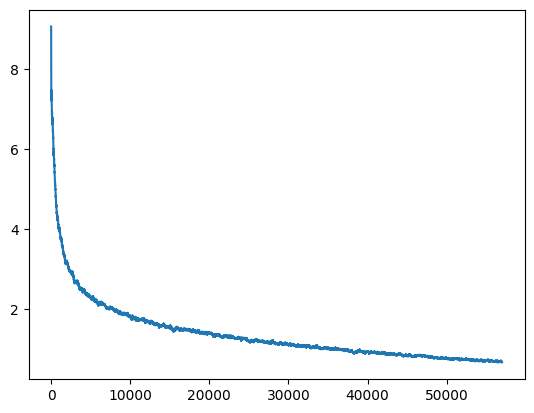

In [17]:
pd.Series(losses3).ewm(100).mean().plot();

In [ ]:
model3_1, tokenizer3_1, losses3_1 = train_model(model3, tokenizer3, df_train_mansi_v1, 'nllb-rus-mansi-v3_1_80k_steps',
                                               training_steps=23001)

  0%|          | 0/23001 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.5535568594932556
Step 500: Average Loss (last 500 steps): 0.6809879175424576


In [85]:
model3_t, tokenizer3_t, losses3_t_train, losses3_t_val = train_model(model3, tokenizer3, df_train_mansi_v1, df_val_mansi_v1,
                         'nllb-rus-mansi-v3_tst', training_steps=1501, validate_every_n_steps=500)

  0%|          | 0/1501 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.5552093982696533
Step 500: Average Loss (last 500 steps): 0.41853840866684916
Step 500: Validation Loss: 2.7669321331712933
Step 1000: Average Loss (last 500 steps): 0.4297396930754185


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss: 2.8669087908097675
Step 1500: Average Loss (last 500 steps): 0.43252759996056556
Step 1500: Validation Loss: 2.8338614236267787


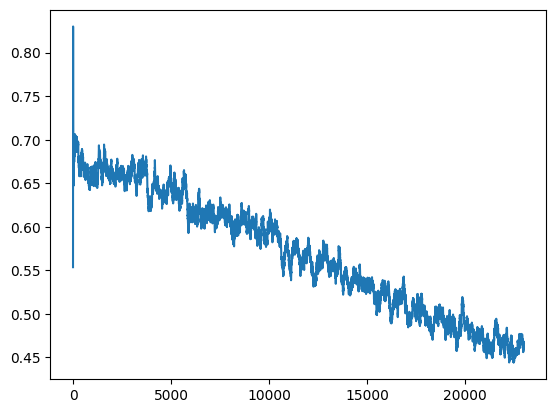

In [18]:
pd.Series(losses3_1).ewm(100).mean().plot();

In [ ]:
model3_2, tokenizer3_2, losses3_2, losses3_2_val = train_model(model3_1, tokenizer3_1, df_train_mansi_v1, df_val_mansi_v1, 
                                                               'nllb-rus-mansi-v3_1_100k_steps', training_steps=20001)

In [ ]:
pd.Series(model3_2).ewm(100).mean().plot();

### model 4
on cleared_v2 => df_train_mansi_v2 data

In [ ]:
model4, tokenizer4, losses4_train, losses4_val = train_model(model, tokenizer, df_train_mansi_v2, df_val_mansi_v2, 
                                                             'nllb-rus-mansi-v4', training_steps=57001)

  0%|          | 0/57001 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 4.649699687957764
Step 500: Average Loss (last 500 steps): 5.475952409744263
Step 1000: Average Loss (last 500 steps): 4.092716766357422


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss: 1.990701176315905


In [ ]:
model4_1, tokenizer4_1, losses4_1_train, losses4_1_val = train_model(model4, tokenizer4, df_train_mansi_v2, df_val_mansi_v2, 
                                                                     'nllb-rus-mansi-v4_1_80k_steps', training_steps=23001)

In [ ]:
model4_2 = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4_1_100k_steps")
model4_2, tokenizer4_2, losses4_2_train, losses4_2_val = train_model(model4_1, tokenizer4_1, df_train_mansi_v2, df_val_mansi_v2, 
                                                                     'nllb-rus-mansi-v4_1_100k_steps', training_steps=20001)

In [ ]:
model4_2 = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4_1_100k_steps")
model4_3, tokenizer4_3, losses4_3_train, losses4_3_val = train_model(model4_2, tokenizer, df_train_mansi_v2, df_val_mansi_v2, 
                                         'nllb-rus-mansi-v4_1_115k_steps', training_steps=15001, validate_every_n_steps=500)

  0%|          | 0/15001 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.4016944169998169
Step 500: Average Loss (last 500 steps): 0.30729883697628974
Step 500: Validation Loss: 1.4188194228224007
Step 1000: Average Loss (last 500 steps): 0.3050956815183163


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss: 1.4049913761127426
Step 1500: Average Loss (last 500 steps): 0.3058183315396309
Step 1500: Validation Loss: 1.4390722923728836
Step 2000: Average Loss (last 500 steps): 0.30012652797996997


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 2000: Validation Loss: 1.4232145812377393
Step 2500: Average Loss (last 500 steps): 0.3029833870828152
Step 2500: Validation Loss: 1.4503287244513332
Step 3000: Average Loss (last 500 steps): 0.3033303126692772


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 3000: Validation Loss: 1.45406936079144
Step 3500: Average Loss (last 500 steps): 0.30230454228818415
Step 3500: Validation Loss: 1.4184936276640758
Step 4000: Average Loss (last 500 steps): 0.3037829732298851


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 4000: Validation Loss: 1.3902639750256596
Step 4500: Average Loss (last 500 steps): 0.3048101869672537
Step 4500: Validation Loss: 1.4235206431892502
Step 5000: Average Loss (last 500 steps): 0.29737868583202365


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 5000: Validation Loss: 1.4210457988532192
Step 5500: Average Loss (last 500 steps): 0.29381827230751517
Step 5500: Validation Loss: 1.4131976643719348


In [16]:
model4_4, tokenizer4_4, losses4_4_train, losses4_4_val = train_model(model4_3, tokenizer, df_train_mansi_v2, df_val_mansi_v2, 
                                         'nllb-rus-mansi-v4_1_120k_steps', training_steps=5001, validate_every_n_steps=500)

  0%|          | 0/5001 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.28534403443336487
Step 500: Average Loss (last 500 steps): 0.2369184822589159
Step 500: Validation Loss: 1.4369964605593777
Step 1000: Average Loss (last 500 steps): 0.2190905921906233


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss: 1.4602499801710427
Step 1500: Average Loss (last 500 steps): 0.24483339090645312
Step 1500: Validation Loss: 1.4211175756521492
Step 2000: Average Loss (last 500 steps): 0.23718033222854137


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 2000: Validation Loss: 1.4457082075766292
Step 2500: Average Loss (last 500 steps): 0.23770728407800198
Step 2500: Validation Loss: 1.4569610004204823
Step 3000: Average Loss (last 500 steps): 0.23573007495701312


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 3000: Validation Loss: 1.44868748506389
Step 3500: Validation Loss: 1.4285627187016499
Step 4000: Average Loss (last 500 steps): 0.2503827274441719


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 4000: Validation Loss: 1.4463880385260983
Step 4500: Average Loss (last 500 steps): 0.23107366500794888
Step 4500: Validation Loss: 1.472776211648581


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [23]:
model4_4, tokenizer4_4, losses4_5_train, losses4_5_val = train_model(model4_4, tokenizer, df_train_mansi_v2, df_val_mansi_v2, 
                                         'nllb-rus-mansi-v4_1_121k_steps', training_steps=1001, validate_every_n_steps=100)

  0%|          | 0/1001 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.36790573596954346
Step 100: Validation Loss: (1.2003391837499229, 1.7612280864792176, 1.4807836351145702)
Step 200: Validation Loss: (1.1860533122078003, 1.7318032601751, 1.45892828619145)
Step 300: Validation Loss: (1.2093997087823338, 1.7267342111671784, 1.468066959974756)
Step 400: Validation Loss: (1.197700979240448, 1.7438896401340225, 1.4707953096872353)
Step 500: Average Loss (last 500 steps): 0.21928987132012845
Step 500: Validation Loss: (1.1776111604698212, 1.7208333647394756, 1.4492222626046485)
Step 600: Validation Loss: (1.1996911524768814, 1.6984556798475334, 1.4490734161622074)
Step 700: Validation Loss: (1.188061343139434, 1.7010138508785202, 1.444537597008977)
Step 800: Validation Loss: (1.196142559788792, 1.6725441969063388, 1.4343433783475654)
Step 900: Validation Loss: (1.1720328433925369, 1.6725933049098556, 1.4223130741511962)
Step 1000: Average Loss (last 500 steps): 0.19123452661931514


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss: (1.1516473527893005, 1.7565357766476979, 1.454091564718499)


### models 5
Same as 4, but with val logs and saving to TensorBoard

In [ ]:
hyperparameters_baseline = {
    'base_model': "NLLB-600m",
    'model_name': "model_4_5",
    'model_folder': "nllb-rus-mansi-v4_1_121k_steps",
    'parent_model': "model_4_5",
    'tokenizer': "NLLB-default+SentencePiece_on_cleared_v2_train_09+mansi_Cyrl_token",
    'train_dataset': "cleared_v2_train_09.csv",
    'learning_rate': 1e-4,
    'optimizer': 'Adafactor_1e-3weight_decay_1clipthreshhold',
    'scheduler': 'constant_schedule_with_warmup_100',
    'train_steps': 1000,
    'total_steps': 121000,
}

In [ ]:
hp = hyperparameters_baseline.copy()
hp["train_steps"] = 57000
hp["total_steps"] = 57000
hp["model_name"] = "model_5"
hp["parent_model"] = None
hp["model_folder"] = "nllb-rus-mansi-v5"

In [ ]:
model, tokenizer, optimizer, scheduler, losses5, val_losses5 = train_model(model, tokenizer, df_train_mansi_v2, df_val_mansi_v2, 
                            'nllb-rus-mansi-v5', experiment_name="model_5", hyperparams=hp, training_steps=57001)

In [94]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_5')

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 20.74 91.7/36.4/10.0/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 46.41

Metrics for translation from ru to mansi
BLEU = 44.18 100.0/57.1/33.3/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 56.03


In [97]:
hp2 = hp.copy()
hp2["train_steps"] = 23000
hp2["total_steps"] = 80000
hp2["model_name"] = "model_5_1"
hp2["parent_model"] = "model_5"
hp2["model_folder"] = "nllb-rus-mansi-v5_1"
model, tokenizer, optimizer, scheduler, losses5_1, val_losses5_1 = train_model(model, tokenizer, df_train_mansi_v2, 
                            df_val_mansi_v2, 'nllb-rus-mansi-v5_1', experiment_name="model_5_1", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp2, training_steps=23000)
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_5_1', steps=23000)

  0%|          | 0/23000 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.47733786702156067
Step 500: Average Loss (last 500 steps): 0.67410294008255
Step 1000: Average Loss (last 500 steps): 0.6516308365166187


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss (lang1 -> lang2): 1.0904079029359013, Validation Loss (lang2 -> lang1): 1.4310737166060024, Combined: 1.2607408097709518
Step 1500: Average Loss (last 500 steps): 0.6403965492844581
Step 2000: Average Loss (last 500 steps): 0.6545938750505448


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 2000: Validation Loss (lang1 -> lang2): 1.1419536282259777, Validation Loss (lang2 -> lang1): 1.463105005193427, Combined: 1.3025293167097023
Step 2500: Average Loss (last 500 steps): 0.6532185037732124
Step 3000: Average Loss (last 500 steps): 0.63385217243433


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 3000: Validation Loss (lang1 -> lang2): 1.104558349613205, Validation Loss (lang2 -> lang1): 1.4350940250009896, Combined: 1.2698261873070973
Step 3500: Average Loss (last 500 steps): 0.6089515027999878
Step 4000: Average Loss (last 500 steps): 0.6149335796236992


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 4000: Validation Loss (lang1 -> lang2): 1.1159325921870618, Validation Loss (lang2 -> lang1): 1.4063653744846942, Combined: 1.261148983335878
Step 4500: Average Loss (last 500 steps): 0.6140446739792824
Step 5000: Average Loss (last 500 steps): 0.6208652850687504


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 5000: Validation Loss (lang1 -> lang2): 1.0966914128586949, Validation Loss (lang2 -> lang1): 1.422768585174438, Combined: 1.2597299990165665
Step 5500: Average Loss (last 500 steps): 0.5944587666392326
Step 6000: Average Loss (last 500 steps): 0.6103000669181347


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 6000: Validation Loss (lang1 -> lang2): 1.1176011629372715, Validation Loss (lang2 -> lang1): 1.4458450078964233, Combined: 1.2817230854168473
Step 6500: Average Loss (last 500 steps): 0.5926406615078449
Step 7000: Average Loss (last 500 steps): 0.5935178463160992


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 7000: Validation Loss (lang1 -> lang2): 1.149116730833628, Validation Loss (lang2 -> lang1): 1.4732941767298073, Combined: 1.3112054537817177
Step 7500: Average Loss (last 500 steps): 0.5931059402823449
Step 8500: Average Loss (last 500 steps): 0.5737082785367966
Step 9000: Average Loss (last 500 steps): 0.5566894578039646


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 9000: Validation Loss (lang1 -> lang2): 1.111146138375064, Validation Loss (lang2 -> lang1): 1.4383134889794162, Combined: 1.27472981367724
Step 9500: Average Loss (last 500 steps): 0.5566291449964047


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Step 20000: Average Loss (last 500 steps): 0.467327974408865


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 20000: Validation Loss (lang1 -> lang2): 1.121591989055695, Validation Loss (lang2 -> lang1): 1.4884469444493214, Combined: 1.3050194667525081
Step 20500: Average Loss (last 500 steps): 0.4475617485940456
Step 21000: Average Loss (last 500 steps): 0.45893158262968065


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 21000: Validation Loss (lang1 -> lang2): 1.1156264493264347, Validation Loss (lang2 -> lang1): 1.4328234396785138, Combined: 1.2742249445024743
Step 21500: Average Loss (last 500 steps): 0.4589446228146553
Step 22000: Average Loss (last 500 steps): 0.43529155871272085


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 22000: Validation Loss (lang1 -> lang2): 1.1460775287754565, Validation Loss (lang2 -> lang1): 1.4622174692919934, Combined: 1.304147499033725
Step 22500: Average Loss (last 500 steps): 0.4390489901304245


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 26.66 90.9/40.0/22.2/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11)
chrF2 = 44.29

Metrics for translation from ru to mansi
BLEU = 23.64 100.0/50.0/10.0/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7)
chrF2 = 49.52


In [98]:
hp3 = hp.copy()
hp3["train_steps"] = 20000
hp3["total_steps"] = 100000
hp3["model_name"] = "model_5_2"
hp3["parent_model"] = "model_5_1"
hp3["model_folder"] = "nllb-rus-mansi-v5_2"
model, tokenizer, optimizer, scheduler, losses5_2, val_losses5_2 = train_model(model, tokenizer, df_train_mansi_v2, 
                            df_val_mansi_v2, 'nllb-rus-mansi-v5_2', experiment_name="model_5_2", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp3, training_steps=20000)
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_5_2', steps=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

Step 0: Average Loss (last 500 steps): 0.36923250555992126
Step 500: Average Loss (last 500 steps): 0.43040125858783723
Step 1000: Average Loss (last 500 steps): 0.4350135344862938


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 1000: Validation Loss (lang1 -> lang2): 1.1890879196814266, Validation Loss (lang2 -> lang1): 1.4699294131443683, Combined: 1.3295086664128974
Step 1500: Average Loss (last 500 steps): 0.4250359645187855
Step 2000: Average Loss (last 500 steps): 0.4184963427484035


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 2000: Validation Loss (lang1 -> lang2): 1.201747962269917, Validation Loss (lang2 -> lang1): 1.4876161670110313, Combined: 1.344682064640474
Step 2500: Average Loss (last 500 steps): 0.4211048320531845
Step 3000: Average Loss (last 500 steps): 0.41857514521479605


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 3000: Validation Loss (lang1 -> lang2): 1.141353391021131, Validation Loss (lang2 -> lang1): 1.47245806527425, Combined: 1.3069057281476906
Step 4000: Average Loss (last 500 steps): 0.41121069237589836


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 4000: Validation Loss (lang1 -> lang2): 1.2099024057388306, Validation Loss (lang2 -> lang1): 1.464547364587286, Combined: 1.3372248851630584
Step 4500: Average Loss (last 500 steps): 0.3962255150079727
Step 5000: Average Loss (last 500 steps): 0.40009052154421804


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 5000: Validation Loss (lang1 -> lang2): 1.1545619138752121, Validation Loss (lang2 -> lang1): 1.5224621803406253, Combined: 1.3385120471079186


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Step 8500: Average Loss (last 500 steps): 0.3779549865722656
Step 9000: Average Loss (last 500 steps): 0.3598750658929348


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 9000: Validation Loss (lang1 -> lang2): 1.1639362901568893, Validation Loss (lang2 -> lang1): 1.4354407105101161, Combined: 1.2996885003335028
Step 9500: Average Loss (last 500 steps): 0.3725953805744648
Step 10000: Average Loss (last 500 steps): 0.361615497648716


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 10000: Validation Loss (lang1 -> lang2): 1.1870977557806606, Validation Loss (lang2 -> lang1): 1.4890579698554962, Combined: 1.3380778628180785
Step 10500: Average Loss (last 500 steps): 0.3619931234419346
Step 11000: Average Loss (last 500 steps): 0.3612769718766212


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 11000: Validation Loss (lang1 -> lang2): 1.1214132435829285, Validation Loss (lang2 -> lang1): 1.420726523820655, Combined: 1.2710698837017917
Step 11500: Average Loss (last 500 steps): 0.35664460983872415
Step 12000: Average Loss (last 500 steps): 0.3593196387887001


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 12000: Validation Loss (lang1 -> lang2): 1.1411565130494206, Validation Loss (lang2 -> lang1): 1.5004689707813492, Combined: 1.3208127419153848
Step 12500: Average Loss (last 500 steps): 0.3465311887264252
Step 13000: Average Loss (last 500 steps): 0.34851352332532404


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 13000: Validation Loss (lang1 -> lang2): 1.1726655656075382, Validation Loss (lang2 -> lang1): 1.5252777524741299, Combined: 1.348971659040834
Step 13500: Average Loss (last 500 steps): 0.34111729177832606
Step 14000: Average Loss (last 500 steps): 0.3396626317501068
Step 14500: Average Loss (last 500 steps): 0.3377478131353855
Step 15000: Average Loss (last 500 steps): 0.3368312710225582


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Step 15000: Validation Loss (lang1 -> lang2): 1.197010306230032, Validation Loss (lang2 -> lang1): 1.5185443785295907, Combined: 1.3577773423798112
Step 15500: Average Loss (last 500 steps): 0.34320342519879343


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Step 19500: Average Loss (last 500 steps): 0.31997132140398027


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 32.47 91.7/36.4/30.0/11.1 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 42.79

Metrics for translation from ru to mansi
BLEU = 44.18 100.0/57.1/33.3/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 67.28


In [100]:
# тест на объединенном test-val отложенном датасете
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_val_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, steps=20000)

Translating batches:   0%|          | 0/491 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/491 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 34.33 91.7/45.5/30.0/11.1 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 42.79

Metrics for translation from ru to mansi
BLEU = 44.18 100.0/57.1/33.3/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 67.28


In [ ]:
hp4 = hp.copy()
hp4["train_steps"] = 15000
hp4["total_steps"] = 115000
hp4["model_name"] = "model_5_3"
hp4["parent_model"] = "model_5_2"
hp4["model_folder"] = "nllb-rus-mansi-v5_3"
model, tokenizer, optimizer, scheduler, losses5_3, val_losses5_3 = train_model(model, tokenizer, df_train_mansi_v2, 
                            df_val_mansi_v2, 'nllb-rus-mansi-v5_3', experiment_name="model_5_3", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp4, training_steps=15000)

In [105]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_5_3', steps=15000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 13.33 83.3/27.3/5.0/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 43.76

Metrics for translation from ru to mansi
BLEU = 44.18 100.0/57.1/33.3/20.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 56.03


### model 6 - AdamW and Cosine Scheduler

In [109]:
from transformers import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Инициализация оптимайзера AdamW
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],  # Параметры модели
    lr=1e-4,  # Learning rate
    weight_decay=1e-3  # Weight decay
)

# Инициализация CosineAnnealingLR scheduler
scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=100000,  # Количество шагов до минимального значения lr
    eta_min=1e-6  # Минимальное значение learning rate
)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [110]:
hp

{'base_model': 'NLLB-600m',
 'model_name': 'model_5',
 'model_folder': 'nllb-rus-mansi-v5_57k_steps',
 'parent_model': None,
 'tokenizer': 'NLLB-default+SentencePiece_on_cleared_v2_train_09+mansi_Cyrl_token',
 'train_dataset': 'cleared_v2_train_09.csv',
 'learning_rate': 0.0001,
 'optimizer': 'Adafactor_1e-3weight_decay_1clipthreshhold',
 'scheduler': 'constant_schedule_with_warmup_100',
 'train_steps': 57001,
 'total_steps': 57001}

In [ ]:
# Гиперпараметры для первой модели 6-го поколения
hp6 = hp.copy()
hp6["train_steps"] = 57000
hp6["total_steps"] = 57000
hp6["model_name"] = "model_6"
hp6["parent_model"] = None
hp6["model_folder"] = "nllb-rus-mansi-v6"
hp6["optimizer"] = "AdamW-lr_1e-4-weight_decay=1e-3"
hp6["scheduler"] = "CosineAnnealingLR-T_max=100000-_eta_min=1e-6"

# Запуск модели 6-го поколения (первая версия)
model, tokenizer, optimizer, scheduler, losses6, val_losses6 = train_model(
    model=model,
    tokenizer=tokenizer,
    train_df=df_train_mansi_v2,
    val_df=df_val_mansi_v2,
    model_save_path="nllb-rus-mansi-v6",
    experiment_name="model_6",
    optimizer=optimizer,  # Передаем AdamW
    scheduler=scheduler,  # Передаем CosineAnnealingLR
    hyperparams=hp6,
    training_steps=57000
)

In [117]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v6")
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_6', steps=57000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 17.75 100.0/44.4/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)
chrF2 = 45.70

Metrics for translation from ru to mansi
BLEU = 23.64 100.0/50.0/10.0/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7)
chrF2 = 51.16


In [ ]:
# Гиперпараметры для второй модели 6-го поколения
hp6_1 = hp6.copy()
hp6_1["train_steps"] = 23000
hp6_1["total_steps"] = 80000
hp6_1["model_name"] = "model_6_1"
hp6_1["parent_model"] = "model_6"
hp6_1["model_folder"] = "nllb-rus-mansi-v6_1"

# Запуск модели 6-го поколения (вторая версия)
model, tokenizer, optimizer, scheduler, losses6_1, val_losses6_1 = train_model(
    model=model,
    tokenizer=tokenizer,
    train_df=df_train_mansi_v2,
    val_df=df_val_mansi_v2,
    model_save_path="nllb-rus-mansi-v6_1",
    experiment_name="model_6_1",
    optimizer=optimizer,  # Передаем AdamW
    scheduler=scheduler,  # Передаем CosineAnnealingLR
    hyperparams=hp6_1,
    training_steps=23000
)

In [116]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v6_1")
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_6_1', steps=23000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 16.52 62.5/28.6/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 27.47

Metrics for translation from ru to mansi
BLEU = 32.17 85.7/50.0/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7)
chrF2 = 33.58


In [ ]:
# Гиперпараметры для третьей модели 6-го поколения
hp6_2 = hp.copy()
hp6_2["train_steps"] = 20000
hp6_2["total_steps"] = 100000
hp6_2["model_name"] = "model_6_2"
hp6_2["parent_model"] = "model_6_1"
hp6_2["model_folder"] = "nllb-rus-mansi-v6_2"

# Запуск модели 6-го поколения (третья версия)
model, tokenizer, optimizer, scheduler, losses6_2, val_losses6_2 = train_model(
    model=model,
    tokenizer=tokenizer,
    train_df=df_train_mansi_v2,
    val_df=df_val_mansi_v2,
    model_save_path="nllb-rus-mansi-v6_2",
    experiment_name="model_6_2",
    optimizer=optimizer,  # Передаем AdamW
    scheduler=scheduler,  # Передаем CosineAnnealingLR
    hyperparams=hp6_2,
    training_steps=20000
)

In [115]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_6_2')

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 16.52 62.5/28.6/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 27.47

Metrics for translation from ru to mansi
BLEU = 32.17 85.7/50.0/20.0/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7)
chrF2 = 33.58


### model 7 - new dataset (cleared_v3.1/small_macrons_changed)

In [14]:
hpb = {
    'base_model': "NLLB-600m",
    'model_name': "model_7",
    'model_folder': "nllb-rus-mansi-v7",
    'parent_model': None,
    'tokenizer': "NLLB-default+SentencePiece_on_cleared_v3.1/small_macrons_changed_train_09+mansi_Cyrl_token",
    'train_dataset': "cleared_v3.1/small_macrons_changed/cleared_v3_train_09.csv",
    'learning_rate': 1e-4,
    'optimizer': 'Adafactor_1e-3weight_decay_1clipthreshhold',
    'scheduler': 'constant_schedule_with_warmup_100',
    'train_steps': 60000,
    'total_steps': 60000,
}

In [ ]:
model, tokenizer, optimizer, scheduler, losses, val_losses = train_model(model, tokenizer, df_train_mansi_v3_1, 
               df_val_mansi_v3_1, 'nllb-rus-mansi-v7', experiment_name="model_7", hyperparams=hpb, training_steps=60000)

In [24]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v3_1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_7')

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 14.11 80.0/22.2/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)
chrF2 = 27.67

Metrics for translation from ru to mansi
BLEU = 13.89 62.5/14.3/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 34.66


In [ ]:
ssh  -L 8080:localhost:8080

ssh -p 40086 root@114.32.64.6 -L 6006:localhost:6006

In [ ]:
hp2 = hpb.copy()
hp2["train_steps"] = 25000
hp2["total_steps"] = 85000
hp2["model_name"] = "model_7_1"
hp2["parent_model"] = "model_7"
hp2["model_folder"] = "nllb-rus-mansi-v7_1"
model, tokenizer, optimizer, scheduler, losses, val_losses = train_model(model, tokenizer, df_train_mansi_v3_1, 
                            df_val_mansi_v3_1, 'nllb-rus-mansi-v7_1', experiment_name="model_7_1", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp2, training_steps=25000)

In [26]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v3_1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_7_1', steps=25000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 24.45 90.0/44.4/12.5/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)
chrF2 = 30.80

Metrics for translation from ru to mansi
BLEU = 25.10 66.7/50.0/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 48.82


In [ ]:
hp3 = hpb.copy()
hp3["train_steps"] = 20000
hp3["total_steps"] = 105000
hp3["model_name"] = "model_7_2"
hp3["parent_model"] = "model_7_1"
hp3["model_folder"] = "nllb-rus-mansi-v7_2"
model, tokenizer, optimizer, scheduler, losses, val_losses = train_model(model, tokenizer, df_train_mansi_v3_1, 
                            df_val_mansi_v3_1, 'nllb-rus-mansi-v7_2', experiment_name="model_7_2", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp3, training_steps=20000)

In [ ]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v3_1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_7_2', steps=20000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 22.09 80.0/33.3/12.5/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)
chrF2 = 45.37

Metrics for translation from ru to mansi
BLEU = 23.36 66.7/37.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 50.91


In [ ]:
hp4 = hpb.copy()
hp4["train_steps"] = 15000
hp4["total_steps"] = 120000
hp4["model_name"] = "model_7_3"
hp4["parent_model"] = "model_7_3"
hp4["model_folder"] = "nllb-rus-mansi-v7_3"
model, tokenizer, optimizer, scheduler, losses, val_losses = train_model(model, tokenizer, df_train_mansi_v3_1, 
                            df_val_mansi_v3_1, 'nllb-rus-mansi-v7_3', experiment_name="model_7_3", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp4, training_steps=15000)

In [ ]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v3_1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_7_3', steps=15000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 20.26 83.3/36.4/10.0/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 53.74

Metrics for translation from ru to mansi
BLEU = 24.27 77.8/37.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 55.94


In [ ]:
hp5 = hpb.copy()
hp5["train_steps"] = 15000
hp5["total_steps"] = 135000
hp5["model_name"] = "model_7_4"
hp5["parent_model"] = "model_7_4"
hp5["model_folder"] = "nllb-rus-mansi-v7_4"
model, tokenizer, optimizer, scheduler, losses, val_losses = train_model(model, tokenizer, df_train_mansi_v3_1, 
                            df_val_mansi_v3_1, 'nllb-rus-mansi-v7_4', experiment_name="model_7_4", optimizer=optimizer, 
                             scheduler = scheduler, hyperparams=hp5, training_steps=15000)

In [ ]:
df_with_transl, metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v3_1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1, log_dir='runs/model_7_4', steps=15000)

## test tensorboard

In [73]:
# test save exps and hyperparemeters
experiment_name = "model_0"
log_dir = f'runs/{experiment_name}'  # Папка для логирования
writer = SummaryWriter(log_dir=log_dir)  # Инициализация TensorBoard

# Пример гиперпараметров
hyperparameters = {
    'learning_rate': 1e-4,
    'optimizer': 'Adafactor',        # Название оптимизатора
    'scheduler': 'ConstantSchedule', # Название scheduler
    'total_steps': 57000             # Число шагов
}

# Пример метрик (если вы хотите их логировать вместе с гиперпараметрами)
metrics = {
    'BLEU_mansi_to_rus': 12,
    'BLEU_rus_to_mansi': 11
}
# Логируем гиперпараметры и метрики
if hyperparameters:
    for key, value in hyperparameters.items():
        if isinstance(value, (int, float)):
            writer.add_scalar(f'Hparams/{key}', value, 0)
        else:
            writer.add_text(f'Hparams/{key}', str(value), 0)

for k, v in metrics.items():
    writer.add_scalar(k, v, 121000)


# Закрываем writer после логирования гиперпараметров и метрик
for i in range(100):
    writer.add_scalar('Training Loss', i, i)
    writer.add_scalar('Val Loss', i*2, i)

writer.close()


# Using the model

## help

## one by one

In [67]:
def evaluate_model(
    model,
    tokenizer,
    df,
    lang_1_code='mansi_Cyrl',
    lang_2_code='rus_Cyrl',
    column_lang_1="mansi",
    column_lang_2="ru",
    num_beams=4,
    a=32,
    b=3,
    max_input_length=1024,
):
    """
    Evaluates the model on the provided dataset, translating between two languages,
    and calculates BLEU and chrF metrics.
    
    Args:
        model: Pretrained sequence-to-sequence model.
        tokenizer: Corresponding tokenizer for the model.
        df: DataFrame with columns containing text in two languages.
        lang_1_code: Source language code for translation (default: 'mansi_Cyrl').
        lang_2_code: Target language code for translation (default: 'rus_Cyrl').
        column_lang_1: Column name in df corresponding to source language 1 (default: 'mansi').
        column_lang_2: Column name in df corresponding to source language 2 (default: 'ru').
        num_beams: Number of beams for beam search (default: 4).
        a: Multiplier for max_new_tokens (default: 32).
        b: Multiplier factor for max_new_tokens relative to input length (default: 3).
        max_input_length: Maximum input token length (default: 1024).
    
    Returns:
        df_t: DataFrame with added columns for translations and metric scores printed.
    """
    model.eval()
    def translate(text, src_lang=lang_1_code, tgt_lang=lang_2_code):
        tokenizer.src_lang = src_lang
        tokenizer.tgt_lang = tgt_lang
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
        result = model.generate(
            **inputs.to(model.device),
            forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
            max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
            num_beams=num_beams,
        )
        return tokenizer.batch_decode(result, skip_special_tokens=True)

    # Prepare BLEU and chrF calculators
    bleu_calc = sacrebleu.metrics.BLEU()
    chrf_calc = sacrebleu.metrics.CHRF()

    # Copy the DataFrame to avoid modification of the original one
    df_t = df.copy()

    # Translate from lang_1_code (e.g., Mansi) to lang_2_code (e.g., Russian)
    df_t[f'{column_lang_2}_translated'] = [translate(t, lang_1_code, lang_2_code)[0] for t in tqdm(df_t[column_lang_1])]
    
    # Translate from lang_2_code (e.g., Russian) to lang_1_code (e.g., Mansi)
    df_t[f'{column_lang_1}_translated'] = [translate(t, lang_2_code, lang_1_code)[0] for t in tqdm(df_t[column_lang_2])]

    # Convert references to list of lists
    references_lang_2 = [[ref] for ref in df_t[column_lang_2].tolist()]
    references_lang_1 = [[ref] for ref in df_t[column_lang_1].tolist()]

    # Calculate and print metrics for both translation directions
    print("Metrics for translation from", lang_1_code, "to", lang_2_code)
    print(bleu_calc.corpus_score(df_t[f'{column_lang_2}_translated'].tolist(), references_lang_2))
    print(chrf_calc.corpus_score(df_t[f'{column_lang_2}_translated'].tolist(), references_lang_2))
    
    print("\nMetrics for translation from", lang_2_code, "to", lang_1_code)
    print(bleu_calc.corpus_score(df_t[f'{column_lang_1}_translated'].tolist(), references_lang_1))
    print(chrf_calc.corpus_score(df_t[f'{column_lang_1}_translated'].tolist(), references_lang_1))

    return df_t

## batched

In [22]:
import sacrebleu
from tqdm.auto import tqdm, trange

def batched_translate(texts, translate_fn, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size, desc="Translating batches"):
        batch_results = translate_fn(texts2[i: i + batch_size], **kwargs)
        results.extend(batch_results)
    return [p for i, p in sorted(zip(idxs, results))]

def evaluate_model_batched(
    model,
    tokenizer,
    df,
    lang_1_code='mansi_Cyrl',
    lang_2_code='rus_Cyrl',
    column_lang_1="mansi",
    column_lang_2="ru",
    num_beams=4,
    a=32,
    b=3,
    max_input_length=1024,
    batch_size=16,
    log_dir=None,
    steps=57000,
):
    """
    Evaluates the model on the provided dataset, translating between two languages
    in batches, and calculates BLEU and chrF metrics.
    
    Args:
        model: Pretrained sequence-to-sequence model.
        tokenizer: Corresponding tokenizer for the model.
        df: DataFrame with columns containing text in two languages.
        lang_1_code: Source language code for translation (default: 'mansi_Cyrl').
        lang_2_code: Target language code for translation (default: 'rus_Cyrl').
        column_lang_1: Column name in df corresponding to source language 1 (default: 'mansi').
        column_lang_2: Column name in df corresponding to source language 2 (default: 'ru').
        num_beams: Number of beams for beam search (default: 4).
        a: Multiplier for max_new_tokens (default: 32).
        b: Multiplier factor for max_new_tokens relative to input length (default: 3).
        max_input_length: Maximum input token length (default: 1024).
        batch_size: Number of samples in each batch for batched translation (default: 16).
    
    Returns:
        df_t: DataFrame with added columns for translations and metric scores printed.
    """
    model.eval()
    def translate_batch(text_batch, src_lang, tgt_lang):
        tokenizer.src_lang = src_lang
        tokenizer.tgt_lang = tgt_lang
        inputs = tokenizer(text_batch, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
        result = model.generate(
            **inputs.to(model.device),
            forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
            max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
            num_beams=num_beams
        )
        return tokenizer.batch_decode(result, skip_special_tokens=True)

    # Prepare BLEU and chrF calculators
    bleu_calc = sacrebleu.metrics.BLEU()
    chrf_calc = sacrebleu.metrics.CHRF()

    # Copy the DataFrame to avoid modification of the original one
    df_t = df.copy()

    # Translate from lang_1_code (e.g., Mansi) to lang_2_code (e.g., Russian) in batches
    df_t[f'{column_lang_2}_translated'] = batched_translate(
        df_t[column_lang_1].tolist(),
        translate_batch,
        batch_size=batch_size,
        src_lang=lang_1_code,
        tgt_lang=lang_2_code
    )
    
    # Translate from lang_2_code (e.g., Russian) to lang_1_code (e.g., Mansi) in batches
    df_t[f'{column_lang_1}_translated'] = batched_translate(
        df_t[column_lang_2].tolist(),
        translate_batch,
        batch_size=batch_size,
        src_lang=lang_2_code,
        tgt_lang=lang_1_code
    )

    # Convert references to list of lists
    references_lang_2 = [[ref] for ref in df_t[column_lang_2].tolist()]
    references_lang_1 = [[ref] for ref in df_t[column_lang_1].tolist()]

    # Calculate and print metrics for both translation directions
    print("Metrics for translation from", column_lang_1, "to", column_lang_2)
    bleu_l1_to_l2 = bleu_calc.corpus_score(df_t[f'{column_lang_2}_translated'].tolist(), references_lang_2)
    print(bleu_l1_to_l2)
    chrf_l1_to_l2 = chrf_calc.corpus_score(df_t[f'{column_lang_2}_translated'].tolist(), references_lang_2)
    print(chrf_l1_to_l2)
    
    print("\nMetrics for translation from", column_lang_2, "to", column_lang_1)
    bleu_l2_to_l1 = bleu_calc.corpus_score(df_t[f'{column_lang_1}_translated'].tolist(), references_lang_1)
    print(bleu_l2_to_l1)
    chrf_l2_to_l1 = chrf_calc.corpus_score(df_t[f'{column_lang_1}_translated'].tolist(), references_lang_1)
    print(chrf_l2_to_l1)

    metrics = {
        f'BLEU_{column_lang_1}_to_{column_lang_2}': bleu_l1_to_l2.score,
        f'chrF2_{column_lang_1}_to_{column_lang_2}': chrf_l1_to_l2.score,
        f'BLEU_{column_lang_2}_to_{column_lang_1}': bleu_l2_to_l1.score,
        f'chrF2_{column_lang_2}_to_{column_lang_1}': chrf_l2_to_l1.score,
    }
    if log_dir is not None:
        writer = SummaryWriter(log_dir=log_dir)
        for k, v in metrics.items():
            writer.add_scalar(k, v, steps)
        writer.close()

    return df_t, metrics

In [12]:
def cleanup():
        """Try to free GPU memory."""
        gc.collect()
        torch.cuda.empty_cache()


def load_nllb_model_and_tokenizer(model_path: str):
    """
    Загружает модель и токенайзер NLLB с диска.

    Args:
        model_path (str): Путь до папки с файлами модели и токенайзера.

    Returns:
        model: Загруженная модель.
        tokenizer: Загруженный токенайзер.
    """
    # Загружаем токенайзер
    # tokenizer = AutoTokenizer.from_pretrained(model_path)
    cleanup()
    model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
    model = model.to("cuda")
    return model #, tokenizer

## results

In [132]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v3")
df_with_metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',log_dir='runs/model_3', steps=57000, num_beams=1)

Translating batches:   0%|          | 0/245 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/245 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 14.11 80.0/22.2/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)
chrF2 = 35.90

Metrics for translation from ru to mansi
BLEU = 19.13 90.0/66.7/6.2/3.6 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10)
chrF2 = 51.78


In [134]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v3_1_80k_steps")
df_with_metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1,log_dir='runs/model_3_1', steps=80000)

Translating batches:   0%|          | 0/245 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/245 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 34.93 100.0/62.5/28.6/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 48.89

Metrics for translation from ru to mansi
BLEU = 22.75 85.7/50.0/10.0/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7)
chrF2 = 48.12


In [135]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v3_1_100k_steps")
df_with_metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v1,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1,log_dir='runs/model_3_2', steps=100000)

Translating batches:   0%|          | 0/245 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/245 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 17.29 75.0/28.6/8.3/5.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 30.29

Metrics for translation from ru to mansi
BLEU = 22.75 85.7/50.0/10.0/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 7 ref_len = 7)
chrF2 = 48.12


In [138]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4")
df_with_metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1,log_dir='runs/model_4', steps=57000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 25.10 88.9/37.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 37.00

Metrics for translation from ru to mansi
BLEU = 31.24 100.0/57.1/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 47.14


In [139]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4_1_80k_steps")
df_with_metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1,log_dir='runs/model_4_1', steps=80000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 16.52 66.7/37.5/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 45.83

Metrics for translation from ru to mansi
BLEU = 59.46 87.5/71.4/50.0/40.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8)
chrF2 = 68.62


In [140]:
model = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4_1_100k_steps")
df_with_metrics = evaluate_model_batched(model, tokenizer, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1,log_dir='runs/model_4_2', steps=100000)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 35.99 92.3/66.7/27.3/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 13 ref_len = 13)
chrF2 = 56.91

Metrics for translation from ru to mansi
BLEU = 25.10 88.9/37.5/14.3/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9)
chrF2 = 61.38


In [35]:
# model4 = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4")
df_with_metrics, metrics = evaluate_model_batched(model4_4, tokenizer4_4, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 15.14 83.3/45.5/5.0/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 47.48

Metrics for translation from ru to mansi
BLEU = 23.70 90.9/50.0/11.1/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11)
chrF2 = 49.51


In [56]:
# model4 = load_nllb_model_and_tokenizer("nllb-rus-mansi-v4")
df_with_transl, metrics = evaluate_model_batched(model4_4, tokenizer4_4, df_test_mansi_v2,
    lang_1_code='mansi_Cyrl',lang_2_code='rus_Cyrl',num_beams=1)

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Translating batches:   0%|          | 0/243 [00:00<?, ?it/s]

Metrics for translation from mansi to ru
BLEU = 15.14 83.3/45.5/5.0/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12)
chrF2 = 47.48

Metrics for translation from ru to mansi
BLEU = 23.70 90.9/50.0/11.1/6.2 (BP = 1.000 ratio = 1.000 hyp_len = 11 ref_len = 11)
chrF2 = 49.51


## check quality

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Metrics for translation from mansi_Cyrl to rus_Cyrl
BLEU = 22.96 66.7/40.0/12.5/8.3 (BP = 1.000 ratio = 1.000 hyp_len = 6 ref_len = 6)
chrF2 = 70.80

Metrics for translation from rus_Cyrl to mansi_Cyrl
BLEU = 42.73 80.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5)
chrF2 = 83.94


,mansi,ru,ind,split,ru_translated,mansi_translated
499,Пономари румакем такви луйгатыянэ.,Друг пономарь сам их поёт.,499,dev,друг пономарь сам её поёт.,Пономари румакем такви луйганэ.


In [214]:
df_with_metrics['mansi_translated'].tolist()

['О̄влах паль.',
 'Пыгрись ловиньтан колн мини.',
 'Во̄рӯйхулытн рēгыӈнувег.',
 'Увсьтен та кос ханьсьтаслум, ат хӯнтлас.',
 '"Маныр тыгле-тувле яласасын?"',
 'Молхо̄тал циркыт сунсыглахтасув э̄лумхо̄лас ти лилипут.',
 'Канимум палытэ ат ме̄тра, па̄ӈхвитэ хурум ме̄тра, карсытэ ме̄тра.',
 'Ма̄н асёйкав матум.',
 'Пономари румакем такви луйгиянэ.',
 'Омам ла̄пкат пуӈкто̄рыл ёвтыс.']

In [215]:
df_with_metrics["mansi"].tolist()

['О̄влах паляге хоса̄г.',
 'Пы̄грись библиотекан мини.',
 'Малтыпнуве  паль ворыт уитын',
 'Увсьтен аквтох та кос ханисьтаслум, ла̄тыӈ ат хӯнтлас.',
 '"Маныр акваг яласэ̄гын?"',
 'Мо̄лхо̄тал ма̄н циркыт сяр талква хумрись ва̄сув – ты лилипут о̄лыс.',
 'Ам о̄лнэ колнакум хосытэ ат мēтра, тав па̄ӈхвитэ хӯрум мēтра, тав лю̄лите хӯрум мēтра.',
 'Мēн ащёйкамен ма̄тум о̄йка.',
 'Пономари румакем такви луйгатыянэ.',
 'Омам ла̄пкат я̄ӈк то̄р ё̄втыс.']

In [216]:
bleu_calc = sacrebleu.metrics.BLEU()
print(bleu_calc.corpus_score(df_with_metrics['mansi_translated'].tolist(), [df_with_metrics["mansi"].tolist()]))

BLEU = 7.61 53.4/18.8/5.3/1.8 (BP = 0.772 ratio = 0.795 hyp_len = 58 ref_len = 73)


In [208]:
print(df_with_metrics['mansi_translated'][8:9].tolist())
print(df_with_metrics["mansi"][8:9].tolist())
bleu_calc = sacrebleu.metrics.BLEU()
print(bleu_calc.corpus_score(df_with_metrics['mansi_translated'][8:9].tolist(), [df_with_metrics["mansi"][8:9].tolist()]))

['Пономари румакем такви луйгиянэ.']
['Пономари румакем такви луйгатыянэ.']
BLEU = 42.73 80.0/50.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5)


In [205]:
"Пономари румакем такви луйг" == "Пономари румакем такви луйг"

True

# Sharing result

## yandex disk

In [ ]:
token = "ya_tokens"

In [ ]:
client = yadisk.Client(token="<token>")
# or
# client = yadisk.Client("<application-id>", "<application-secret>", "<token>")

# You can either use the with statement or manually call client.close() later
with client:
    # Check if the token is valid
    print(client.check_token())

    # Get disk information
    print(client.get_disk_info())

    # Print files and directories at "/some/path"
    print(list(client.listdir("/some/path")))

    # Upload "file_to_upload.txt" to "/destination.txt"
    client.upload("file_to_upload.txt", "/destination.txt")

    # Same thing
    with open("file_to_upload.txt", "rb") as f:
        client.upload(f, "/destination.txt")

    # Download "/some-file-to-download.txt" to "downloaded.txt"
    client.download("/some-file-to-download.txt", "downloaded.txt")

    # Permanently remove "/file-to-remove"
    client.remove("/file-to-remove", permanently=True)

    # Create a new directory at "/test-dir"
    print(client.mkdir("/test-dir"))